<a href="https://colab.research.google.com/github/Glasiermedic/Boosting-examples/blob/master/Mass_Schooling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Massachusetts School System
## Analysis prediction

### Data Exploration
#### I am very interested in identifying the current contributing factors for graduation rates, college admission test scores and 4 yr. college attendance rates in Massachusetts schools.  In this project I will first identity any trends or notable statistics around the variables. 

### Data cleaning and preparation
#### I will filter out features that add no value to the prediction like the school name, street address and city name.  I will also address any features that contain missing or placeholder data.  I will fit the data to a scale allowing the models to be more effective, utlize a correlation matrix and a random forest algorithm to determine the feature importance and if needed use Boruta to refine our features down to a managable and efficient set.  

### Modeling and model validation. 
#### As a part of the project I will define our exact question we will answer, identify the metric we will measure and create a model for predicting the outcome of our metric.  

##### Data used for this project came from the repository on Kaggle posted by [Nigel Dalziel](https://www.kaggle.com/ndalziel/massachusetts-public-schools-data#MA_Public_Schools_2017.csv).  Data compiled from [Massachusetts Department of Education ]http://profiles.doe.mass.edu/state_report/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
#!pip install boruta
!pip3 install seaborn==0.9.0

#from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler 
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestRegressor
#from boruta import boruta_py
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt


In [0]:
mass_ed = pd.read_csv("https://raw.githubusercontent.com/Glasiermedic/Massachusetts-Schools/master/MA_Public_Schools_2017.csv", thousands = ",")

In [3]:
mass_ed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1861 entries, 0 to 1860
Columns: 302 entries, School Code to District_Progress and Performance Index (PPI) - High Needs Students
dtypes: float64(267), int64(19), object(16)
memory usage: 4.3+ MB


In [0]:
for i in range(0,len(mass_ed['School Type'])):
  if (mass_ed['School Type'][i]) == 'Public School':
    mass_ed.at[i,'School Type']= 0
  else: 
    mass_ed.at[i,'School Type']= 1


In [5]:
mass_ed['School Type'].unique()

array([0, 1], dtype=object)

In [0]:
import re

def multiple_replacer(*key_values):
    replace_dict = dict(key_values)
    replacement_function = lambda match: replace_dict[match.group(0)]
    pattern = re.compile("|".join([re.escape(k) for k, v in key_values]), re.M)
    return lambda string: pattern.sub(replacement_function, string)

def multiple_replace(string, *key_values):
    return multiple_replacer(*key_values)(string)
  
  
replacements = (' ','_'), ('%', 'percent'), ('#', 'num'), ('(1-99)', "")
#Example:  multiple_replace("Sales % with #people", *replacements))

In [0]:
ed_col = []
ed_columns =[]
for col in mass_ed.columns:
  ed_col.append(multiple_replace(col, *replacements))
for item in ed_col:
  ed_columns.append(item.lower())
#print(ed_columns) 

In [0]:
mass_ed = mass_ed.replace(np.NAN, 0)

In [0]:
mass_ed.columns = ed_columns

In [0]:
mass_ed = mass_ed.drop(['school_code', 'function', 'contact_name', 'address_1', 'address_2', 'town', 'state', 'zip', 'phone', 'fax', 'grade', 'district_name', 'district_code'], axis = 1)

In [11]:
%%time 

def data_preprocess(x):
  if (x['1_enrollment'] > 1) and (x['11_enrollment']> 1) and (x['6_enrollment'] > 1):
    x['school_type'] = 0
  if (x['pk_enrollment'] > 1) and (x['1_enrollment'] < 1):
    x['school_type'] = 4  
  elif (x['9_enrollment'] +  x['10_enrollment'] +  x['11_enrollment'] +  x['12_enrollment']) > 1:
    x['school_type'] = 3
  elif (x['7_enrollment'] > 1):
    x['school_type'] = 2
  else:
    x['school_type'] = 1
  
  return x
  
  

#mass_ed_copy.apply(lambda x: x['1_enrollment'], axis=1)
mass_ed = mass_ed.apply(lambda x: data_preprocess(x), axis=1)

CPU times: user 599 ms, sys: 16.7 ms, total: 615 ms
Wall time: 617 ms


In [12]:
mass_ed_high = mass_ed.loc[mass_ed['school_type']==3]
mass_ed_high.describe()

,school_type,pk_enrollment,k_enrollment,1_enrollment,2_enrollment,3_enrollment,4_enrollment,5_enrollment,6_enrollment,7_enrollment,...,percent_mcas_10thgrade_english_w/f,mcas_10thgrade_english_stud._incl._num,mcas_10thgrade_english_cpi,mcas_10thgrade_english_sgp,mcas_10thgrade_english_incl._in_sgp(num),school_accountability_percentile_,progress_and_performance_index_(ppi)_-_all_students,progress_and_performance_index_(ppi)_-_high_needs_students,district_progress_and_performance_index_(ppi)_-_all_students,district_progress_and_performance_index_(ppi)_-_high_needs_students
count,386.0,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,...,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.00000
mean,3.0,0.207254,3.284974,3.443005,3.279793,3.243523,3.266839,5.813472,11.238342,19.733161,...,2.093264,162.007772,84.419430,41.791451,142.455959,42.800518,62.932642,54.668394,63.303109,59.15285
std,0.0,2.943370,18.244277,18.774067,18.416381,18.425780,18.326300,26.261946,34.546865,46.309224,...,3.997610,139.683678,32.499896,22.092660,122.546909,32.272848,30.528090,32.072303,17.752961,15.93982
min,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,55.500000,93.300000,35.125000,45.250000,11.250000,58.000000,47.000000,53.000000,54.00000
50%,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,120.500000,97.800000,46.750000,111.500000,42.000000,71.000000,65.000000,63.000000,57.00000
75%,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,260.250000,99.200000,56.750000,221.500000,71.000000,83.000000,76.000000,72.750000,68.00000
max,3.0,54.000000,178.000000,182.000000,183.000000,191.000000,191.000000,244.000000,242.000000,386.000000,...,44.000000,925.000000,100.000000,88.000000,757.000000,99.000000,100.000000,100.000000,100.000000,100.00000


In [13]:
mass_ed_high['percent_attending_college'].describe()

count    386.000000
mean      63.158808
std       30.580845
min        0.000000
25%       54.625000
50%       75.500000
75%       85.700000
max      100.000000
Name: percent_attending_college, dtype: float64

In [0]:
mass_ed_high = mass_ed_high[mass_ed_high.percent_attending_college != 0]

In [15]:
print ("most frequent precentage of college attendance: \n{} \n".format(mass_ed_high['percent_attending_college'].value_counts().head(10)))

print ("less frequent precentage of college attendance: \n{} \n".format(mass_ed_high['percent_attending_college'].value_counts().tail(10)))

most frequent precentage of college attendance: 
87.5    5
87.7    4
89.9    4
89.3    4
71.4    4
89.5    4
76.6    3
87.9    3
84.6    3
72.8    3
Name: percent_attending_college, dtype: int64 

less frequent precentage of college attendance: 
58.6    1
91.7    1
52.4    1
45.6    1
33.6    1
84.4    1
47.7    1
40.7    1
42.6    1
69.3    1
Name: percent_attending_college, dtype: int64 



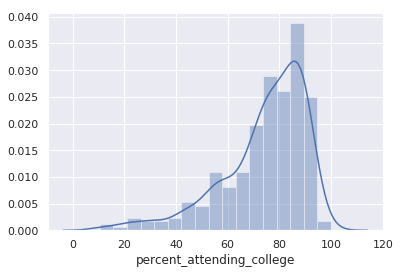

In [16]:
sns.distplot(mass_ed_high['percent_attending_college'])

plt.savefig('percent_college.png')

### Selecting Features

#### For the purposes of this project we are looking at factors that we use to predict the college attendance of students.  Variables that relate to graduating high school and post high school aternatives have been excluded from the possible feature list.  Including gender, socio-economic and ethnical variables was also considered.  It was determined that including gender, ethic data and thee economic-status with the understanding that we are not intending to shift the percentages to improve a schools college attendance outcomes, rather to hightlight that a need for further investigation maybe needed.  

In [0]:
# This cell allows for the exclusion of gender, economic status and ethnicity. 

#mass_ed_high.drop(['economically_disadvantaged',
#       'percent_economically_disadvantaged', 'percent_african_american',
#      'percent_asian', 'percent_hispanic', 'percent_white',
#       'percent_native_american', 'percent_native_hawaiian,_pacific_islander',
#       'percent_multi-race,_non-hispanic', 'percent_males', 'percent_females'])

In [18]:
X_prep = mass_ed_high.drop(['high_school_graduates_(num)', 'percent_umass', 'percent_private_two-year', 'percent_public_two-year', 'percent_ma_community_college', 'percent_private_four-year', 'percent_mcas_10thgrade_english_a', 'percent_ma_state_university', 'attending_coll./univ._(num)', 'percent_public_four-year', 'percent_attending_college', 'school_name', 'high_needs', 'economically_disadvantaged', 'percent_mcas_10thgrade_english_p+a', 'accountability_and_assistance_level', 'accountability_and_assistance_description', 'progress_and_performance_index_(ppi)_-_all_students', 'progress_and_performance_index_(ppi)_-_high_needs_students', 'district_accountability_and_assistance_level', 'district_accountability_and_assistance_description', 'district_progress_and_performance_index_(ppi)_-_all_students', 'district_progress_and_performance_index_(ppi)_-_high_needs_students'],axis =1)
#X = mass_ed_high.drop(['percent_attending_college'],axis =1)

y = mass_ed_high['percent_attending_college'] 
print(y.shape)
print (X_prep.shape)

(328,)
(328, 266)


#### The data needs to be scaled for some of the machine learning models.  In most instances the performance of the models improves with scaling.  

In [0]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X_prep,y))
X.columns =X_prep.columns
X.school_type = X_prep.school_type
X.school_type = X.school_type.replace(np.NAN, 0)

In [0]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits =5, random_state=1)

In [21]:
forest = RandomForestRegressor(max_depth=7,n_jobs=-1, random_state=1, n_estimators=100, verbose=0)
forest.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

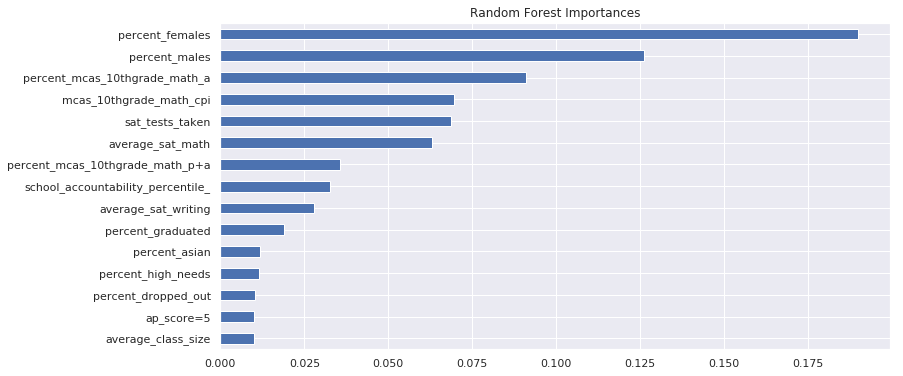

In [22]:
importances_for = forest.feature_importances_

indices = np.argsort(importances_for)[::-1]
for_imp_feat = []

for f in range(X.shape[1]):
    for_imp_feat.append(X.columns[indices[f]])

importances_df = pd.Series(importances_for, index=X.columns)
importances_df.nlargest(15).sort_values().plot(kind='barh', figsize=(12, 6)) 
plt.title("Random Forest Importances")
plt.show()

In [23]:
import xgboost as xgb
xg_reg_lin = xgb.XGBRegressor(objective ='reg:linear', 
                          learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
  nthread=4,
 scale_pos_weight=1, random_state =1)

xg_reg_lin.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=4, objective='reg:linear', random_state=1, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

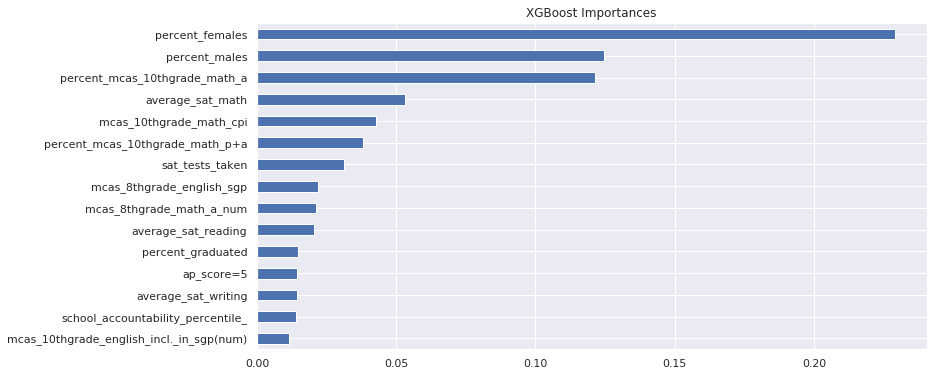

In [24]:
importances_xgb = xg_reg_lin.feature_importances_

indices = np.argsort(importances_xgb)[::-1]
xgb_imp_feat = []

for f in range(X.shape[1]):
    xgb_imp_feat.append(X.columns[indices[f]])

importances_df = pd.Series(importances_xgb, index=X.columns)
importances_df.nlargest(15).sort_values().plot(kind='barh', figsize=(12, 6)) 
plt.title("XGBoost Importances")
plt.show()


In [25]:
from sklearn import linear_model

lasso = linear_model.Lasso(alpha=0.9, copy_X=True, fit_intercept=False, max_iter=300,
   normalize=True, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)
lasso.fit(X,y)

Lasso(alpha=0.9, copy_X=True, fit_intercept=False, max_iter=300,
   normalize=True, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
#np.argsort(lasso.coef_)[::-1]



In [0]:
#X.columns[abs(lasso.coef_) > 10**-6]

#X.columns[23]

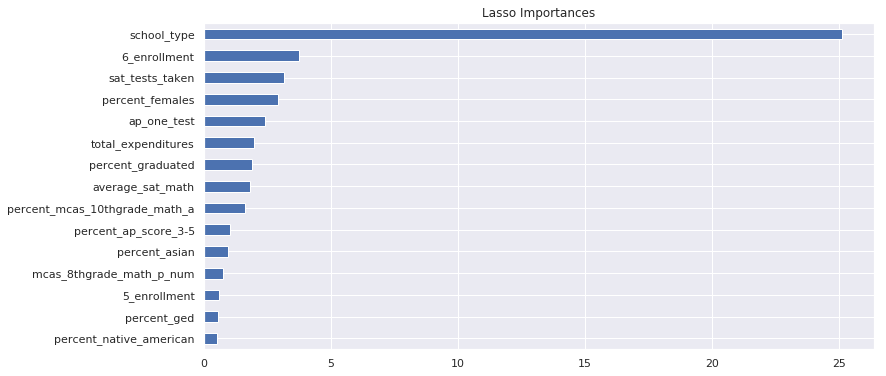

In [27]:
indices = np.argsort(lasso.coef_)[::-1]
lasso_imp_feat = []

for f in range(X.shape[1]):
    lasso_imp_feat.append(X.columns[indices[f]])

importances_df = pd.Series(lasso.coef_, index=X.columns)
importances_df.nlargest(15).sort_values().plot(kind='barh', figsize=(12, 6)) 
plt.title("Lasso Importances")
plt.show()

In [28]:
# Function to find common elements in n arrays 
def commonElements(arr): 
	
	# initialize result with first array as a set 
	result = set(arr[0]) 

	# now iterate through list of arrays starting from 
	# second array and take intersection_update() of 
	# each array with result. Every operation will 
	# update value of result with common values in 
	# result set and intersected set 
	for currSet in arr[1:]: 
		result.intersection_update(currSet) 

	return list(result) 

 
arr = [lasso_imp_feat[:80], xgb_imp_feat[:80], for_imp_feat[:80]] 
output = commonElements(arr) 
if len(output) > 0: 
	print (len(output))
else: 
	print ('No Common Elements Found')


16


In [29]:
output 

['salary_totals',
 'percent_ap_score_3-5',
 'average_sat_math',
 'total_num_of_classes',
 'percent_females',
 'sat_tests_taken',
 'percent_multi-race,_non-hispanic',
 'percent_ged',
 'average_class_size',
 'percent_asian',
 'percent_english_language_learner',
 'average_sat_reading',
 'percent_native_american',
 'percent_mcas_10thgrade_math_a',
 '6_enrollment',
 'percent_graduated']

In [30]:
X_for = X[list(for_imp_feat)[:16]]

X_xgb = X[list(xgb_imp_feat)[:16]]

X_lasso = X[list(lasso_imp_feat)[:16]]
X_lasso24 = X[list(lasso_imp_feat)[:24]]

X_out =X[list(output)]

feat_list = [X_for, X_xgb, X_lasso, X_lasso24, X_out]
print_list =['Random Forest', 'XGBoost', 'Lasso', 'Lasso_24', 'Combined']

X_out.shape


(328, 16)

### Lasso models 
#### Logic loop running through the four feature importance lists generated.  Grid search with cross validation is used to select the best parameters for the model.  


In [31]:
%%time
alpha_list = [.012, .014, .015 , .018, .020, .022, .024, .025, .026, .27, .028, .3, .32, .1]
parameters = {'alpha': alpha_list,
                    'fit_intercept': [True,False], 
                    'normalize' :[True], 'max_iter':[40, 45, 50, 55, 60]}

for i in range (0,5):
  X_train, X_test, y_train, y_test = train_test_split(feat_list[i], y, random_state =1, test_size = 0.2)
  
  print ("------ " +print_list[i] + " -------")
  lasso_grid = GridSearchCV(lasso, parameters, cv=kfolds, scoring='neg_mean_squared_error')
  lasso_grid.fit(X_train,y_train)        
  print (lasso_grid.best_estimator_)
  print(-lasso_grid.best_score_)
  
  y_pred_lasso = lasso_grid.predict(X_test)

------ Random Forest -------
Lasso(alpha=0.028, copy_X=True, fit_intercept=True, max_iter=45,
   normalize=True, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)
95.35152401252064
------ XGBoost -------
Lasso(alpha=0.012, copy_X=True, fit_intercept=True, max_iter=60,
   normalize=True, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)
82.50386798398752
------ Lasso -------
Lasso(alpha=0.026, copy_X=True, fit_intercept=True, max_iter=40,
   normalize=True, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)
78.11402453134106
------ Lasso_24 -------
Lasso(alpha=0.028, copy_X=True, fit_intercept=True, max_iter=40,
   normalize=True, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)
80.35399512463069
------ Combined -------
Lasso(alpha=0.012, copy_X=True, fit_intercept=True, max_ite

Random Forest

In [32]:
%%time
forest = RandomForestRegressor(max_depth=7,n_jobs=-1, random_state=1, n_estimators=100, verbose=0)


alpha_list = [.012, .014, .015 , .018, .020, .022, .024, .025, .026, .028, .1]
parametersr = {'max_depth': [ 16], 'n_estimators': [900]}

#for i in range (0,5):
X_train, X_test, y_train, y_test = train_test_split(X_lasso24, y, random_state =1, test_size = 0.2)
  
print ("------ Lasso Importance -------")
forest_grid = GridSearchCV(forest, parametersr, cv=kfolds, scoring='neg_mean_squared_error')
forest_grid.fit(X_train,y_train)
print (forest_grid.best_estimator_)
print(-forest_grid.best_score_)
  
  
y_pred_forest = forest_grid.predict(X_test)

------ Lasso Importance -------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=900, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)
73.9110562025264
CPU times: user 7.7 s, sys: 701 ms, total: 8.4 s
Wall time: 13.2 s


XGBoost

In [33]:
%%time
xg_reg_lin = xgb.XGBRegressor(objective ='reg:linear', gamma=0, max_leaf_nodes=2, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, random_state =1)

parametersg2 = {'gamma':[i/50.0 for i in range(6,10)], 'subsample':[i/10.0 for i in range(3,5)], 'learning_rate': [.025], 'max_depth': [5], 'n_estimators': [250], 'min_child_weight':[8],
 'colsample_bytree':[i/10.0 for i in range(6,8)]}

#parametersg1 = {'learning_rate': [.024, .025, .026], 'max_depth': [3, 4], 'n_estimators': [200, 250, 300], 'min_child_weight':[7,8,9]}

#for i in range (0):
X_train, X_test, y_train, y_test = train_test_split(X_lasso24, y, random_state =1, test_size = 0.2)
  
print ("------ Lasso Importance -------")
xgb_grid = GridSearchCV(xg_reg_lin, parametersg2, cv=kfolds, scoring='neg_mean_squared_error')
xgb_grid.fit(X_train,y_train)
print (xgb_grid.best_estimator_)
print(-xgb_grid.best_score_)
  
#xgb_grid.fit(X,y)  
#y_pred_xgb = xgb_grid.predict(X)

------ Lasso Importance -------
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.14, importance_type='gain',
       learning_rate=0.025, max_delta_step=0, max_depth=5,
       max_leaf_nodes=2, min_child_weight=8, missing=None,
       n_estimators=250, n_jobs=1, nthread=4, objective='reg:linear',
       random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.3)
69.54890388189907
CPU times: user 21.2 s, sys: 5.2 s, total: 26.4 s
Wall time: 14.3 s


#### This section fine tunes the number of features for the XGBoost model.  The optimum number of features with the fine tuning of hyperparameters produces the best results at 24 features.  

In [34]:
%%time
xg_reg_lin = xgb.XGBRegressor(objective ='reg:linear', gamma=0, max_leaf_nodes=2, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, random_state =1)

parametersg2 = {'gamma':[i/50.0 for i in range(6,10)], 'subsample':[i/10.0 for i in range(3,5)], 'learning_rate': [.025], 'max_depth': [5], 'n_estimators': [250], 'min_child_weight':[8],
 'colsample_bytree':[i/10.0 for i in range(6,8)]}

#parametersg1 = {'learning_rate': [.024, .025, .026], 'max_depth': [3, 4], 'n_estimators': [200, 250, 300], 'min_child_weight':[7,8,9]}

feat_list2 = [X[list(lasso_imp_feat)[:30]], X[list(lasso_imp_feat)[:29]], X[list(lasso_imp_feat)[:28]],  X[list(lasso_imp_feat)[:27]], X[list(lasso_imp_feat)[:26]], X[list(lasso_imp_feat)[:25]], X[list(lasso_imp_feat)[:24]], X[list(lasso_imp_feat)[:23]], X[list(lasso_imp_feat)[:22]]]
print_list2 = ['30', '29', '28', '27', '26', '25', '24', '23', '22']
final = '24 features'
for i in range (0,9):
  X_train, X_test, y_train, y_test = train_test_split(feat_list2[i], y, random_state =1, test_size = 0.2)
  
  print ("------ " + print_list2[i] +" -------")
  xgb_grid = GridSearchCV(xg_reg_lin, parametersg2, cv=kfolds, scoring='neg_mean_squared_error')
  xgb_grid.fit(X_train,y_train)
  print (xgb_grid.best_estimator_)
  print(-xgb_grid.best_score_)

------ 30 -------
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.12, importance_type='gain',
       learning_rate=0.025, max_delta_step=0, max_depth=5,
       max_leaf_nodes=2, min_child_weight=8, missing=None,
       n_estimators=250, n_jobs=1, nthread=4, objective='reg:linear',
       random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.4)
68.2541824248936
------ 29 -------
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.12, importance_type='gain',
       learning_rate=0.025, max_delta_step=0, max_depth=5,
       max_leaf_nodes=2, min_child_weight=8, missing=None,
       n_estimators=250, n_jobs=1, nthread=4, objective='reg:linear',
       random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.4)
67.88113725577197
------ 28 -------
XGBRegressor(base_score=0.5, booster=

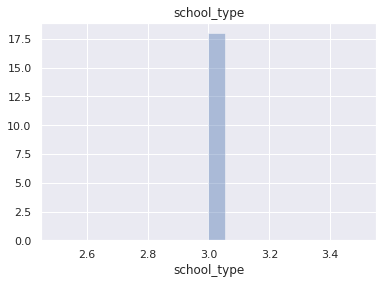

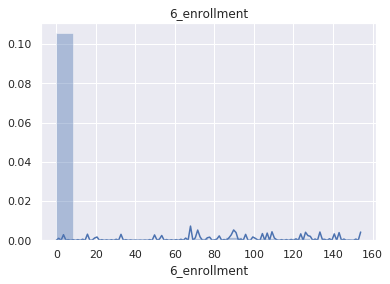

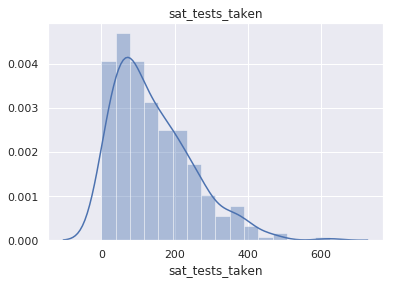

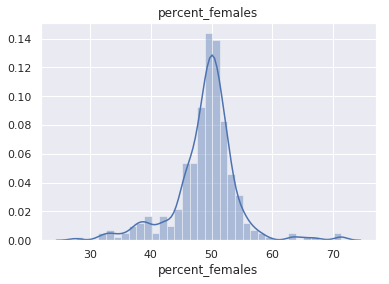

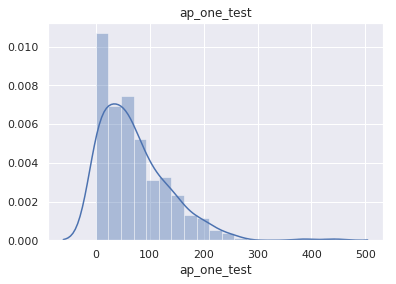

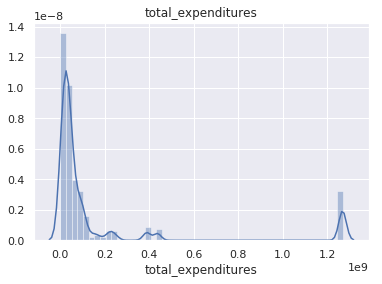

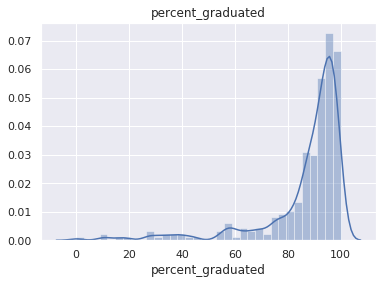

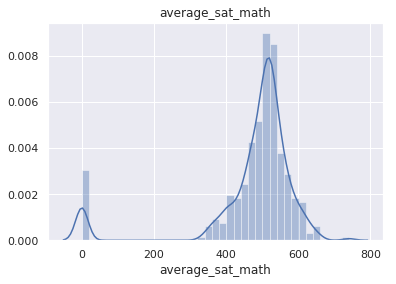

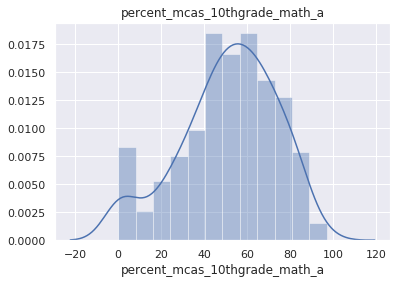

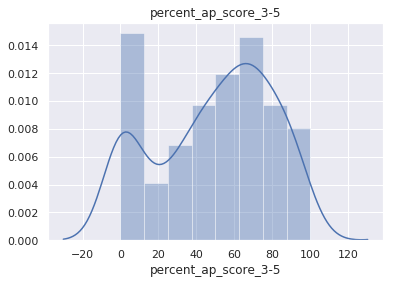

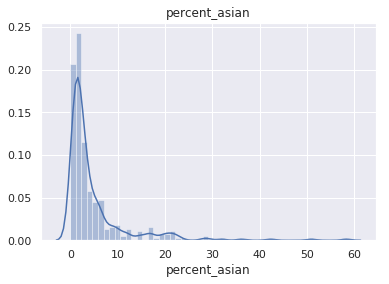

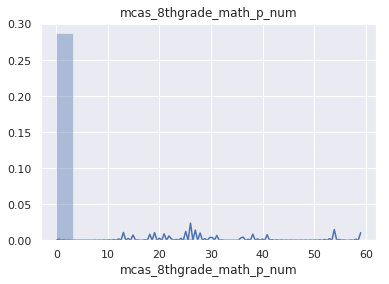

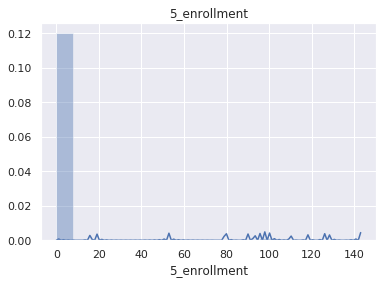

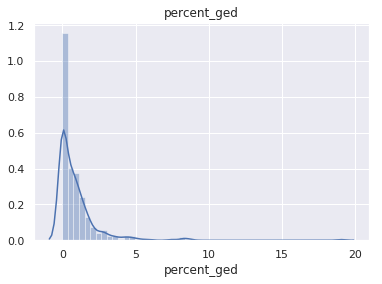

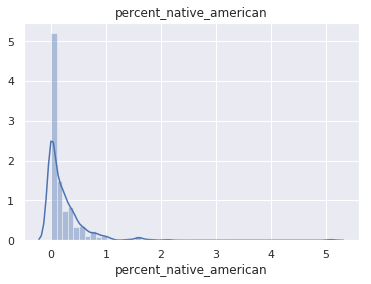

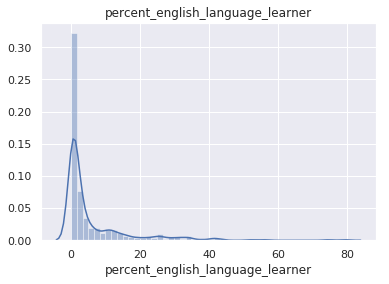

In [35]:
for col in X_lasso:
  sns.distplot(mass_ed_high[col])
  plt.title(col)
  plt.show()

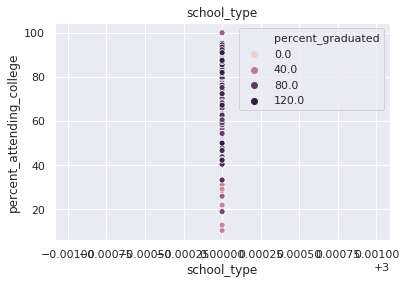

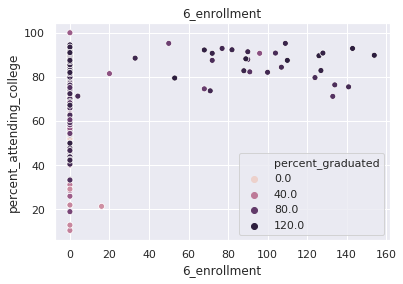

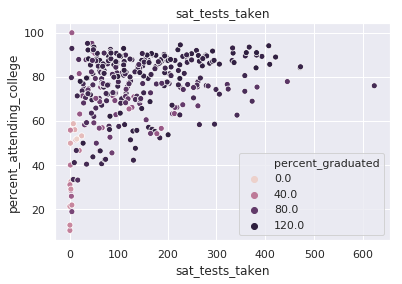

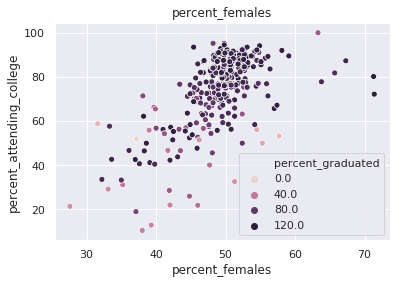

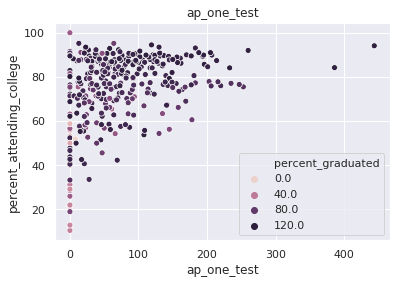

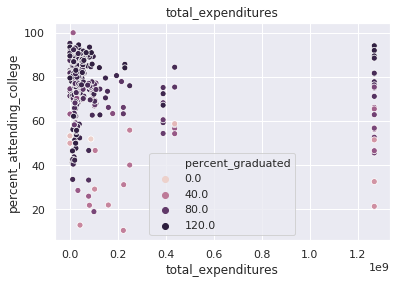

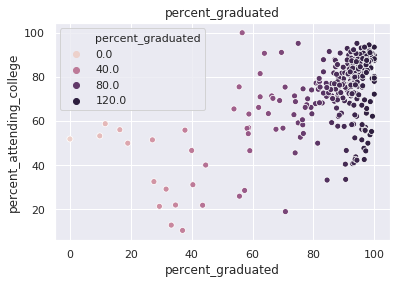

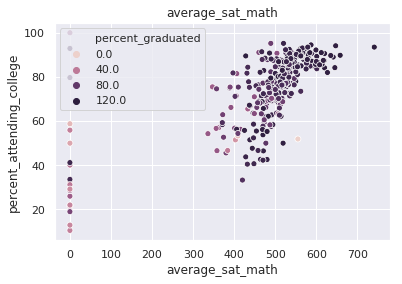

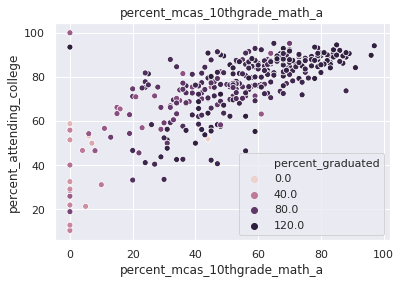

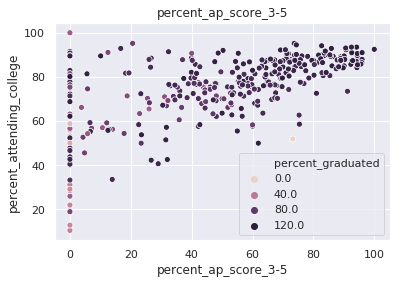

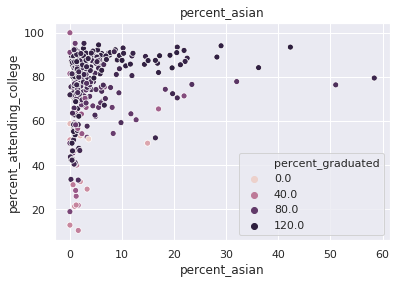

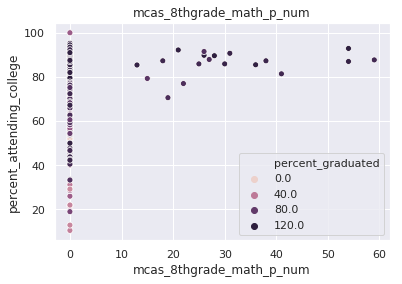

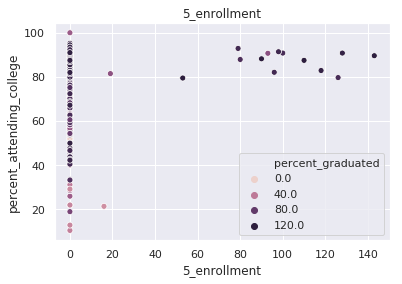

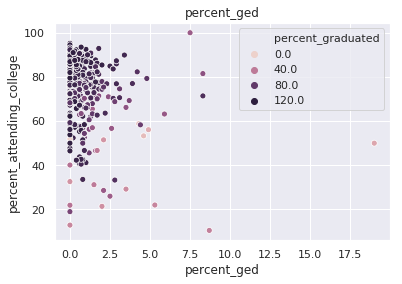

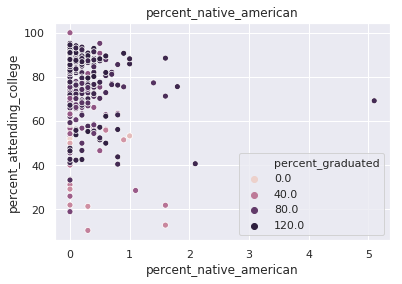

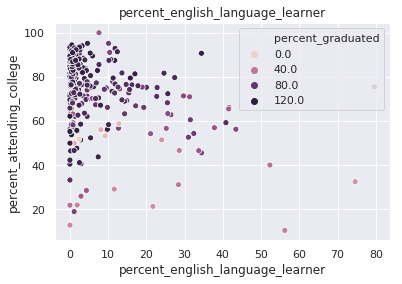

In [36]:
for col in X_lasso:
  plt.title(col)
  sns.scatterplot(x = col, y ='percent_attending_college', data = mass_ed_high, hue = "percent_graduated" )
  plt.show()

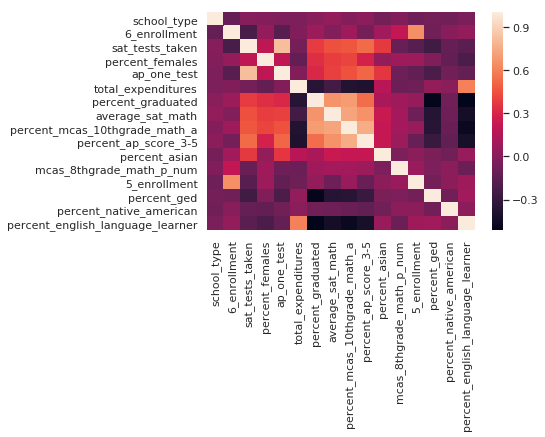

In [37]:
corr = X_lasso.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [38]:
print (y_pred_xgb.shape)




#X_lasso['error']= abs(y_pred_xgb-y)

NameError: ignored